# Popular Data Science Questions

Our goal in this project is to use Data Science Stack Exchange to determine what content should a data science education company create, based on interest by subject.


Running a few exploratory queries, leads to focus our efforts on Posts table. For examples, the Tags table looked very promising as it tells us how many times each tag was used, but there's no way to tell just from this if the interest in these tags is recent or a thing from the past.

## Getting the Data
To get the relevant data we run the following query in Stack Exchange Data Explorer (https://data.stackexchange.com/datascience/query/new).

SELECT Id, CreationDate,
       Score, ViewCount, Tags,
       AnswerCount, FavoriteCount
FROM posts
WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;
 
Later we download the queried data in a csv format file.

In [337]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [338]:
questions=pd.read_csv('questions2019.csv',parse_dates=['CreationDate'])
questions

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,56937,2019-08-04 20:18:38,0,93,<regression><visualization><categorical-data><...,0,NaN
1,56939,2019-08-04 20:53:45,0,20,<r><correlation>,0,NaN
2,56940,2019-08-04 21:34:46,1,47,<data>,1,1.0
3,56944,2019-08-04 23:43:26,2,504,<deep-learning><keras><pytorch>,0,2.0
4,56947,2019-08-05 01:23:08,0,14,<svm><multilabel-classification>,0,NaN
...,...,...,...,...,...,...,...
8228,52987,2019-05-31 15:31:56,1,46,<python><random-forest><matlab>,1,NaN
8229,52989,2019-05-31 15:40:23,1,82,<classification>,1,1.0
8230,52990,2019-05-31 15:42:29,0,39,<weka>,0,NaN
8231,52992,2019-05-31 16:39:44,0,92,<python><lda-classifier>,1,NaN


In [339]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8233 entries, 0 to 8232
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             8233 non-null   int64         
 1   CreationDate   8233 non-null   datetime64[ns]
 2   Score          8233 non-null   int64         
 3   ViewCount      8233 non-null   int64         
 4   Tags           8233 non-null   object        
 5   AnswerCount    8233 non-null   int64         
 6   FavoriteCount  1501 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 450.4+ KB



We see that only FavoriteCount has missing values. A missing value on this column probably means that the question was is not present in any users' favorite list, so we can replace the missing values with zero.

The types seem adequate for every column, however, after we fill in the missing values on FavoriteCount, there is no reason to store the values as floats.

In [340]:
questions['FavoriteCount']=questions['FavoriteCount'].fillna(0)
questions['FavoriteCount']=questions['FavoriteCount'].astype(int)

Since the object dtype is a catch-all type, let's see what types the objects in questions["Tags"] are.

In [341]:
questions['Tags'].apply(lambda value: type(value)).unique()

array([<class 'str'>], dtype=object)


We see that every value in this column is a string. On Stack Exchange, each question can only have a maximum of five tags (source), so one way to deal with this column is to create five columns in questions called Tag1, Tag2, Tag3, Tag4, and Tag5 and populate the columns with the tags in each row.

In [342]:
questions['Tags']=questions['Tags'].str.replace('^<|>$','').str.split('><')

In [343]:
questions.sample(3)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
1445,54634,2019-06-27 17:21:49,0,11,[image],0,0
995,44456,2019-01-23 17:29:04,2,345,"[python, deep-learning, keras]",1,1
6507,61236,2019-10-04 05:19:04,1,175,"[pandas, similar-documents]",1,0


In [344]:
tag_count= dict()

for tags in questions['Tags']:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] +=1
        else:
            tag_count[tag]=1

tag_count

{'regression': 324,
 'visualization': 123,
 'categorical-data': 79,
 'topic-model': 28,
 'r': 254,
 'correlation': 79,
 'data': 196,
 'deep-learning': 1131,
 'keras': 872,
 'pytorch': 163,
 'svm': 128,
 'multilabel-classification': 90,
 'tensorflow': 541,
 'nlp': 462,
 'natural-language-process': 116,
 'text-mining': 101,
 'sentiment-analysis': 34,
 'spacy': 20,
 'python': 1706,
 'scoring': 11,
 'reinforcement-learning': 185,
 'policy-gradients': 26,
 'matplotlib': 75,
 'machine-learning': 2534,
 'neural-network': 998,
 'classification': 644,
 'graphs': 47,
 'cnn': 453,
 'computer-vision': 113,
 'transfer-learning': 64,
 'automation': 4,
 'pandas': 342,
 'feature-selection': 195,
 'score': 13,
 'discriminant-analysis': 5,
 'time-series': 426,
 'preprocessing': 114,
 'machine-learning-model': 214,
 'decision-trees': 134,
 'boosting': 48,
 'dataset': 314,
 'clustering': 252,
 'image-classification': 195,
 'multiclass-classification': 124,
 'object-detection': 96,
 'transformer': 44,
 'rn

In [345]:
tag_count=pd.DataFrame.from_dict(tag_count,orient='index')
tag_count.rename(columns={0:'Count'},inplace=True)
tag_count.head(10)

,Count
regression,324
visualization,123
categorical-data,79
topic-model,28
r,254
correlation,79
data,196
deep-learning,1131
keras,872
pytorch,163


In [346]:
most_used=tag_count.sort_values(by='Count',ascending=False).head(20)
most_used

,Count
machine-learning,2534
python,1706
deep-learning,1131
neural-network,998
keras,872
classification,644
tensorflow,541
scikit-learn,503
nlp,462
cnn,453


The threshold of 20 is somewhat arbitrary and we can experiment with others, however, popularity of the tags rapidly declines, so looking at these tags should be enough to help us with our goal. Let's visualize these data

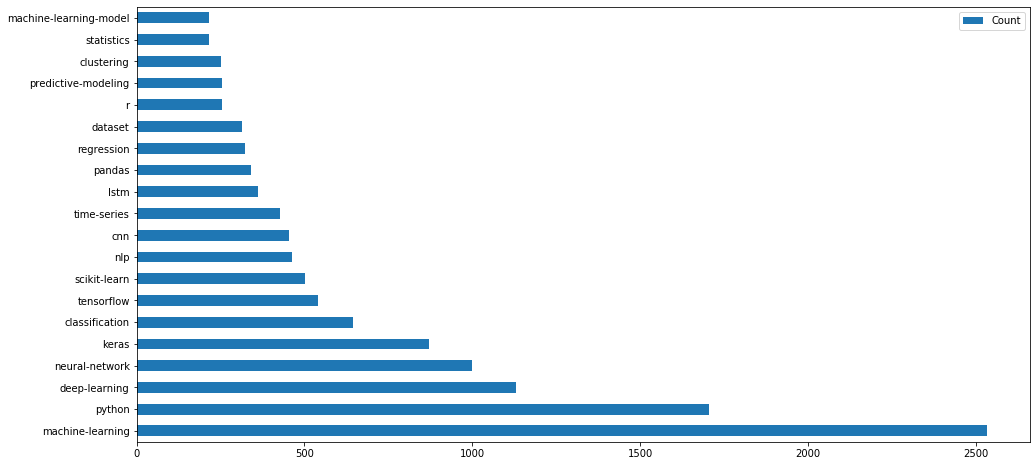

In [347]:
most_used.plot(kind='barh',figsize=(16,8))

Some tags are very, very broad and are unlikely to be useful; e.g.: python, dataset, r. Before we investigate the tags a little deeper, let's repeat the same process for views.

In [348]:
view_tag_count= dict()

for idx,tags in enumerate(questions['Tags']):
    for tag in tags:
        if tag in view_tag_count:
            view_tag_count[tag] += questions['ViewCount'].iloc[idx]
        else:
            view_tag_count[tag] = questions['ViewCount'].iloc[idx]
            
view_tag_count

{'regression': 85328,
 'visualization': 35422,
 'categorical-data': 23617,
 'topic-model': 4186,
 'r': 63289,
 'correlation': 21167,
 'data': 33862,
 'deep-learning': 406457,
 'keras': 485391,
 'pytorch': 78441,
 'svm': 24006,
 'multilabel-classification': 18342,
 'tensorflow': 229983,
 'nlp': 133915,
 'natural-language-process': 17899,
 'text-mining': 21012,
 'sentiment-analysis': 5674,
 'spacy': 7694,
 'python': 1061357,
 'scoring': 4792,
 'reinforcement-learning': 32132,
 'policy-gradients': 2596,
 'matplotlib': 52642,
 'machine-learning': 693757,
 'neural-network': 333852,
 'classification': 185916,
 'graphs': 9612,
 'cnn': 133662,
 'computer-vision': 58273,
 'transfer-learning': 20635,
 'automation': 193,
 'pandas': 460712,
 'feature-selection': 50595,
 'score': 2689,
 'discriminant-analysis': 874,
 'time-series': 117554,
 'preprocessing': 33878,
 'machine-learning-model': 41801,
 'decision-trees': 40230,
 'boosting': 12145,
 'dataset': 75238,
 'clustering': 60278,
 'image-classif

In [349]:
view_tag_count=pd.DataFrame.from_dict(view_tag_count,orient='index')
view_tag_count.rename(columns={0:'ViewCount'},inplace=True)
most_viewed=view_tag_count.sort_values('ViewCount',ascending=False).head(20)
most_viewed

,ViewCount
python,1061357
machine-learning,693757
keras,485391
pandas,460712
deep-learning,406457
neural-network,333852
scikit-learn,248214
tensorflow,229983
classification,185916
dataframe,180143


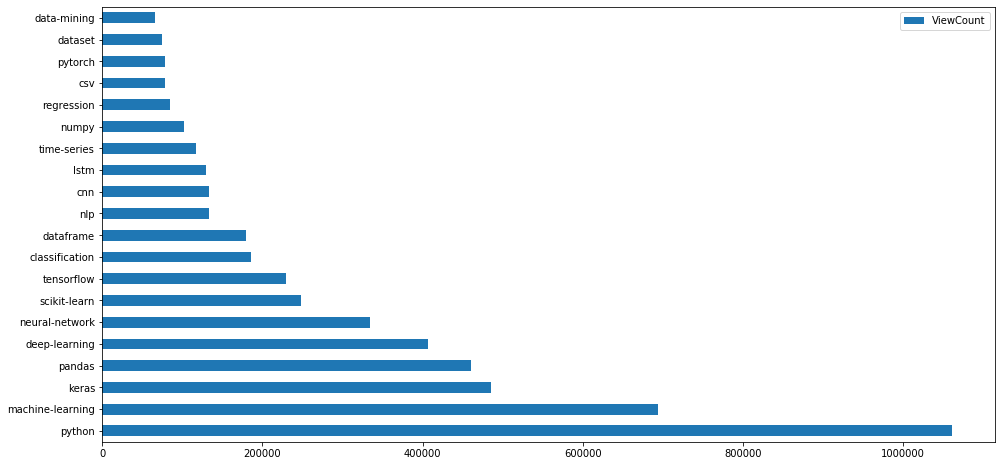

In [350]:
most_viewed.plot(kind='barh',figsize=(16,8))

Let's see them side by side.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D4BD179E48>],
      dtype=object)

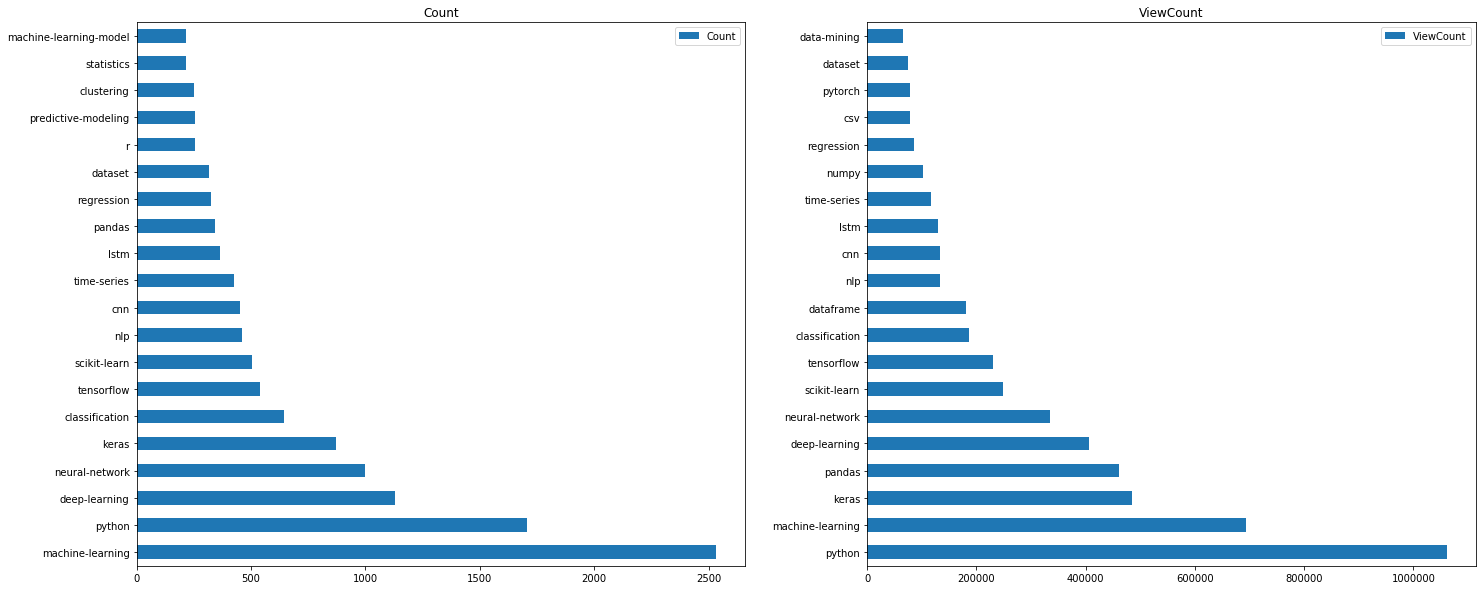

In [351]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24, 10))
most_used.plot(kind="barh", ax=axes[0], subplots=True)
most_viewed.plot(kind="barh", ax=axes[1], subplots=True)

In [352]:
in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True)
in_viewed = pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True)

In [353]:
in_used

,Count,ViewCount
machine-learning,2534,693757.0
python,1706,1061357.0
deep-learning,1131,406457.0
neural-network,998,333852.0
keras,872,485391.0
classification,644,185916.0
tensorflow,541,229983.0
scikit-learn,503,248214.0
nlp,462,133915.0
cnn,453,133662.0


In [354]:
in_viewed

,Count,ViewCount
python,1706.0,1061357
machine-learning,2534.0,693757
keras,872.0,485391
pandas,342.0,460712
deep-learning,1131.0,406457
neural-network,998.0,333852
scikit-learn,503.0,248214
tensorflow,541.0,229983
classification,644.0,185916
dataframe,NaN,180143


The tags present in most_used and not present in most_viewed are:

* machine-learning-model
* statistics
* predictive-modeling
* r

And the tags present in most_viewed but not in most_used are:

* csv
* pytorch
* dataframe

## Relations Between Tags
One way of trying to gauge how pairs of tags are related to each other, is to count how many times each pair appears together. Let's do this.

We'll begin by creating a list of all tags.

In [355]:
all_tags=list(tag_count.index)


In [356]:
associations=pd.DataFrame(index=all_tags,columns=all_tags)
associations.fillna(0, inplace=True)
associations.iloc[0:4,0:4]

,regression,visualization,categorical-data,topic-model
regression,0,0,0,0
visualization,0,0,0,0
categorical-data,0,0,0,0
topic-model,0,0,0,0


In [357]:
for tags in questions["Tags"]:
    associations.loc[tags, tags] += 1

In [358]:
relations_most_used = associations.loc[most_used.index, most_used.index]
relations_most_used

,machine-learning,python,deep-learning,neural-network,keras,classification,tensorflow,scikit-learn,nlp,cnn,time-series,lstm,pandas,regression,dataset,r,predictive-modeling,clustering,statistics,machine-learning-model
machine-learning,2534,476,400,349,182,243,97,176,108,116,120,60,61,114,95,58,120,61,86,135
python,476,1706,147,131,263,94,151,218,69,56,97,56,236,58,50,23,36,45,33,37
deep-learning,400,147,1131,292,233,55,125,13,65,150,39,95,1,21,28,5,31,2,11,17
neural-network,349,131,292,998,224,62,104,21,24,111,31,63,1,42,20,9,13,7,11,10
keras,182,263,233,224,872,54,245,27,20,109,46,118,3,31,11,10,11,0,2,15
classification,243,94,55,62,54,644,18,42,34,18,22,15,3,32,24,9,26,12,16,21
tensorflow,97,151,125,104,245,18,541,10,10,50,9,32,3,9,9,1,6,0,0,8
scikit-learn,176,218,13,21,27,42,10,503,12,0,10,1,36,37,6,1,12,23,5,17
nlp,108,69,65,24,20,34,10,12,462,7,0,17,3,2,10,3,0,9,3,4
cnn,116,56,150,111,109,18,50,0,7,453,7,21,1,5,10,2,6,0,1,4


In [359]:
for i in range(relations_most_used.shape[0]):
    relations_most_used.iloc[i,i] = pd.np.NaN

C:\Users\Filip.Mazurkiewicz\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


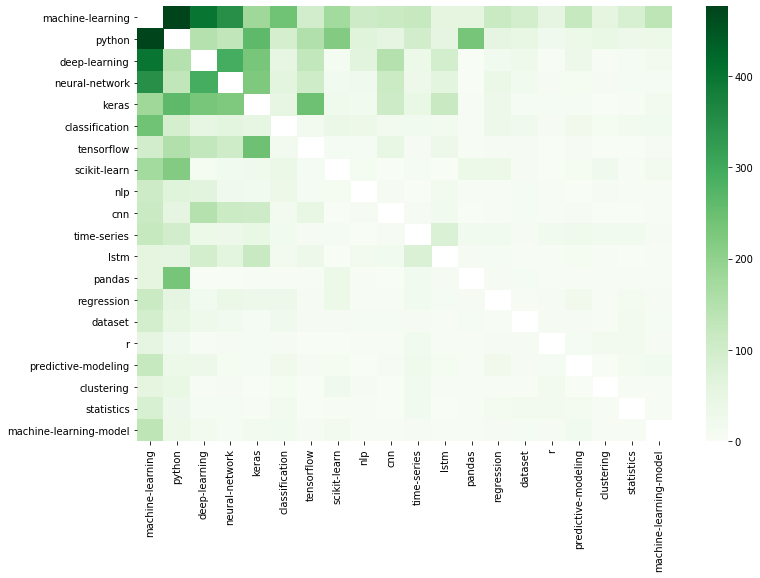

In [360]:
plt.figure(figsize=(12,8))
sns.heatmap(relations_most_used, cmap="Greens", annot=False)

The most used tags also seem to have the strongest relationships, as given by the dark concentration in the bottom right corner. However, this could simply be because each of these tags is used a lot, and so end up being used together a lot without possibly even having any strong relation between them.

A more intuitive manifestation of this phenomenon is the following. A lot of people buy bread, a lot of people buy toilet paper, so they end up being purchased together a lot, but purchasing one of them doesn't increase the chances of purchasing the other.

Another shortcoming of this attempt is that it only looks at relations between pairs of tags and not between multiple groups of tags. For example, it could be the case that when used together, dataset and scikit-learn have a "strong" relation to pandas, but each by itself doesn't.

So how do we attack both these problems? There is a powerful data mining technique that allows us to handle this: association rules. Association rules allow us to analytically spot relations like "people who purchase milk, also purchase eggs". Moreover, we can also measure how strong this relations are on several fronts: how common the relation is, how strong it is, and how independent the components of the relationship are (toilet paper and bread are probably more independent than eggs and milk — you'll learn more about statistical independence) in the next step).

We won't get into the details of it, as the technique is out of scope for this course, but it is a path worth investigating!

## Enter Domain Knowledge
Keras, scikit-learn, TensorFlow are all Python libraries that allow their users to employ deep learning (a type of neural network).

Most of the top tags are all intimately related with one central machine learning theme: deep learning. If we want to be very specific, we can suggest the creation of Python content that uses deep learning for classification problems (and other variations of this suggestion).

At the glance of an eye, someone with sufficient domain knowledge can tell that the most popular topic at the moment, as shown by our analysis, is deep learning.

In [361]:
all_q = pd.read_csv("all_questions.csv", parse_dates=["CreationDate"])

In [362]:
all_q["Tags"] = all_q["Tags"].str.replace("^<|>$", "").str.split("><")

Before deciding which questions should be classified as being deep learning questions, we should decide what tags are deep learning tags.

The definition of what constitutes a deep learning tag we'll use is: a tag that belongs to the list ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"].

This list was obtained by looking at all the tags in most_used and seeing which ones had any relation to deep learning. You can use Google and read the tags descriptions to reach similar results.

We'll now create a function that assigns 1 to deep learning questions and 0 otherwise; and we use it.

In [363]:
def class_deep_learning(tags):
    for tag in tags:
        if tag in ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"]:
            return 1
    return 0

all_q["DeepLearning"] = all_q["Tags"].apply(class_deep_learning)

In [365]:
all_q.drop(columns=['Score','ViewCount','AnswerCount','FavoriteCount'], inplace=True)

In [366]:
all_q.sample(3)

,Id,CreationDate,Tags,DeepLearning
14550,60261,2019-09-16 08:50:27,"[nlp, lstm, nlg]",1
16446,68098,2020-02-14 15:53:13,"[machine-learning, python, decision-trees, mac...",0
17980,5844,2015-05-20 13:24:33,"[python, survival-analysis]",0


Looks good!

The data-science-techonology landscape isn't something as dynamic to merit daily, weekly, or even monthly tracking. Let's track it quarterly.

Since we don't have all the data for the first quarter of 2020, we'll get rid of those dates:

In [367]:
all_q=all_q[all_q['CreationDate'].dt.year<2020]
all_q

,Id,CreationDate,Tags,DeepLearning
0,6760,2015-08-11 09:26:26,"[nlp, topic-model]",0
1,6765,2015-08-11 19:28:29,"[machine-learning, data-mining, r, predictive-...",0
2,6768,2015-08-11 22:21:42,"[machine-learning, python, svm, scikit-learn]",1
3,6773,2015-08-12 14:01:23,[r],0
4,6774,2015-08-12 14:16:42,"[python, markov-process]",0
...,...,...,...,...
23988,8642,2015-10-29 10:30:39,"[machine-learning, classification]",0
23989,8645,2015-10-29 12:33:07,"[python, visualization]",0
23990,8646,2015-10-29 12:42:35,"[machine-learning, algorithms, predictive-mode...",0
23991,8649,2015-10-29 16:18:45,[probability],0


Let's create a column that identifies the quarter in which a question was asked.

In [368]:

def fetch_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month-1) // 3) + 1)
    return "{y}Q{q}".format(y=year, q=quarter)

all_q["Quarter"] = all_q["CreationDate"].apply(fetch_quarter)

In [369]:
all_q.head()

,Id,CreationDate,Tags,DeepLearning,Quarter
0,6760,2015-08-11 09:26:26,"[nlp, topic-model]",0,15Q3
1,6765,2015-08-11 19:28:29,"[machine-learning, data-mining, r, predictive-...",0,15Q3
2,6768,2015-08-11 22:21:42,"[machine-learning, python, svm, scikit-learn]",1,15Q3
3,6773,2015-08-12 14:01:23,[r],0,15Q3
4,6774,2015-08-12 14:16:42,"[python, markov-process]",0,15Q3


For the final stretch of this screen, we'll group by quarter and:

Count the number of deep learning questions.
Count the total number of questions.
Compute the ratio between the two numbers above

In [374]:
quarterly = all_q.groupby('Quarter').agg({"DeepLearning": ['sum', 'size']})
quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']
quarterly["DeepLearningRate"] = quarterly["DeepLearningQuestions"]\
                                /quarterly["TotalQuestions"]
# The following is done to help with visualizations later.
quarterly.reset_index(inplace=True)
quarterly.sample(5)

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
4,15Q2,28,284,0.098592
19,19Q1,711,1762,0.403519
0,14Q2,9,157,0.057325
21,19Q3,938,2379,0.394283
5,15Q3,45,311,0.144695


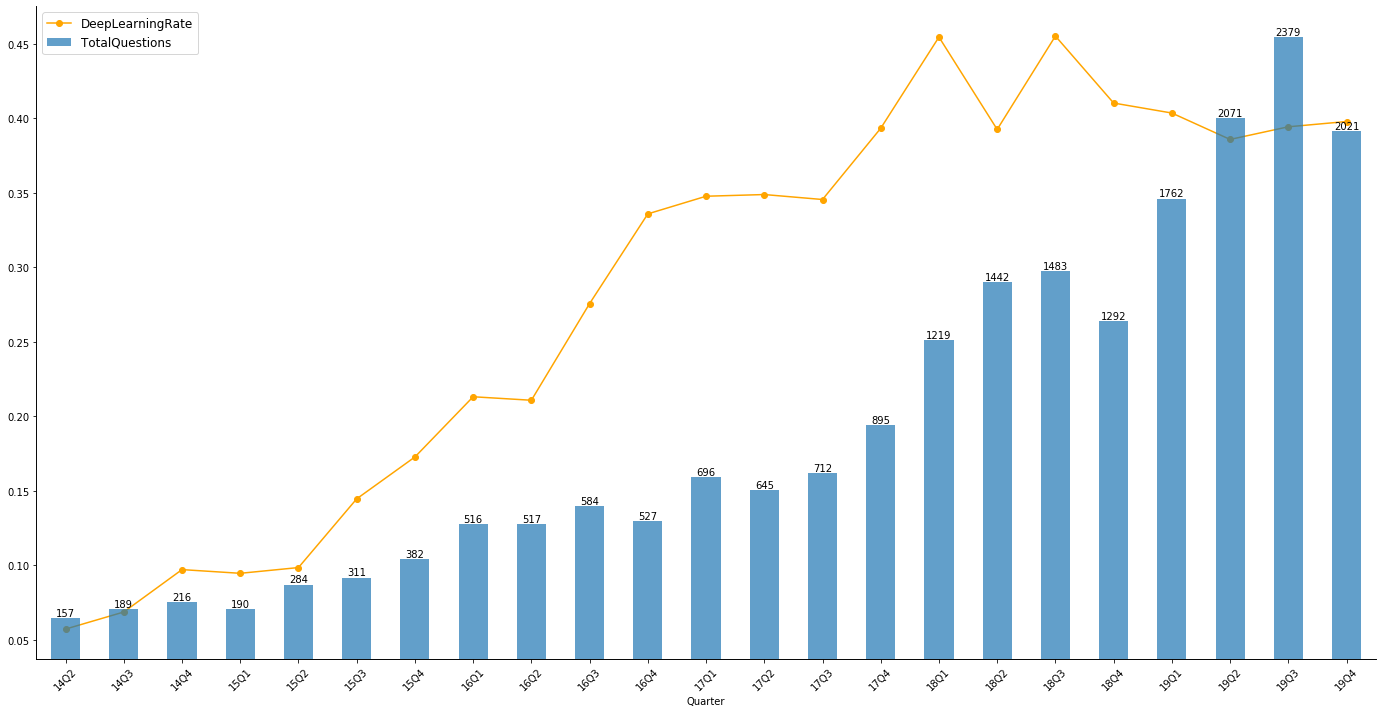

In [371]:
ax1 = quarterly.plot(x="Quarter", y="DeepLearningRate",
                    kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(24,12)
                    )

ax2 = quarterly.plot(x="Quarter", y="TotalQuestions",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in enumerate(quarterly["TotalQuestions"]):
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)


It seems that deep learning questions was a high-growth trend since the start of DSSE and it looks like it is plateauing. There is no evidence to suggest that interest in deep learning is decreasing and so we maintain our previous idea of proposing that we create deep learning content.